<h1>Project Data Mining</h1>
<br><h2>Sentiment Analysis on tweets</h2>
<br><b>Editors: </b>
<br>Aslanidis Theofanis - Athinaios Konstantinos

<b>1)</b> Importing all needed packages: <br>
<ul>
    <li><b>nltk:</b> used for tokenization
    <li><b>pandas:</b> data representation
    <li><b>WordCloud:</b> data representation
<ul>


In [110]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame 
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer, word_tokenize, TweetTokenizer
from wordcloud import WordCloud

#nltk.download('punkt')
#nltk.download('stopwords')

<b>2)</b> Loading tweeter datasets for training and testing:
<ul>
    <li><u>Value</u> for negative-positive-neutral
    <li><u>Tweet</u> for the text
</ul>

In [35]:
train_data = pd.read_csv("../twitter_data/train2017.tsv", names=['Value', 'Tweet'], sep='\t', usecols = [2, 3])
test_data = pd.read_csv("../twitter_data/test2017.tsv", names=['Value', 'Tweet'], sep='\t', usecols = [2, 3])
train_data.head()

,Value,Tweet
0,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,negative,"Theo Walcott is still shit, watch Rafa and Joh..."
2,negative,"its not that I'm a GSP fan, i just hate Nick D..."
3,negative,Iranian general says Israel's Iron Dome can't ...
4,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ti..."


<h4>Our pipeline:</h4><br>
<ol>
    <li>Load the raw text.
    <li>Split into tokens.
    <li>Convert to lowercase.
    <li>Filter out tokens that are stop words.
    <li>Stemming
</ol>
<br>    
<b>Tokenize tweets and convert all to lowercase</b>


In [82]:
tweets = []
values = []
tokenizer = TweetTokenizer()
for tweet in train_data.T:
    tweets.append(tokenizer.tokenize(train_data.T[tweet][1].lower()))
    values.append(train_data.T[tweet][0])

<b>Remove Stop Words</b>

In [134]:
# filter out stop words
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
for x in range(0,len(tweets)):
    tweets[x] = [token for token in tweets[x] if not token in stop_words and token.isalpha()]

<b>Stemming (Reducing each word to its root).</b>

In [38]:
# stemming of words
from nltk.stem.porter import PorterStemmer

stemmed = []
porter = PorterStemmer()
for x in range(0,len(tweets)):
    stemmed.append([porter.stem(token) for token in tweets[x]])

In [39]:
print(tweets[0], "\n", stemmed[0])

['gas', 'house', 'hit', '$', '3.39', '!', '!', '!', "i'm", 'going', 'chapel', 'hill', 'sat', '.', ':)'] 
 ['ga', 'hous', 'hit', '$', '3.39', '!', '!', '!', "i'm", 'go', 'chapel', 'hill', 'sat', '.', ':)']


<h2>Data Analysis</h2>
<br><h4>Characteristics:</h4>
<ul>
    <li><b>Most Frequent</b> words in whole training dataset.
    <li><b>Most Frequent Positive, Negative and Neutral </b> words.
<ul>

In [135]:
# %%capture
from collections import Counter
total_counter=Counter()
positive_counter = Counter()
negative_counter = Counter()
neutral_counter = Counter()
j=0
for i in tweets[0:]: 
    total_counter.update(i)
    if(values[j] == "positive"):
        positive_counter.update(i)
    if(values[j] == "negative"):
        negative_counter.update(i)
    if(values[j] == "neutral"):
        neutral_counter.update(i)
    j+=1
dict(total_counter)
dict(positive_counter)
dict(negative_counter)
dict(neutral_counter)

data = {'Total': total_counter, 'Positive': positive_counter, 'Negative': negative_counter, 'Neutral': neutral_counter}
fp = DataFrame(data, index =total_counter.keys(), columns =['Total','Positive','Negative', 'Neutral'])
fp

,Total,Positive,Negative,Neutral
gas,13,4.0,2.0,7.0
house,267,96.0,25.0,146.0
hit,131,43.0,21.0,67.0
going,2088,824.0,318.0,946.0
chapel,14,6.0,2.0,6.0
hill,33,14.0,4.0,15.0
sat,578,220.0,106.0,252.0
theo,5,1.0,1.0,3.0
walcott,3,NaN,1.0,2.0
still,758,279.0,167.0,312.0


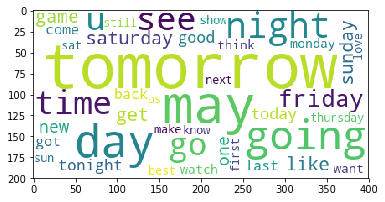

In [136]:
# Display the generated image:
wc = WordCloud(stopwords=stopwords, background_color="white", max_words=40).generate_from_frequencies(total_counter)
plt.imshow(wc)

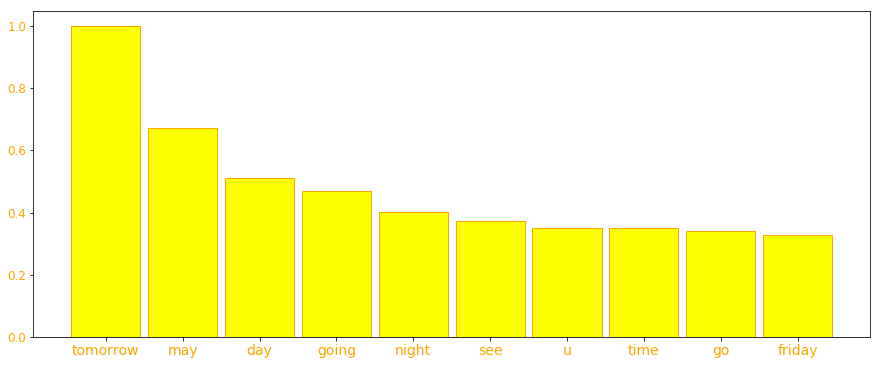

In [137]:
# Choose the names of the bars
words = list(wc.words_.keys())
freq = list(wc.words_.values())
#np array
y_pos = np.arange(len(words[:10]))

#size
plt.figure(figsize=(15,6))

# Create bars
plt.bar(y_pos, freq[:10], edgecolor='orange', color='yellow', width=0.9)
 
# Create names on the x-axis
plt.xticks(y_pos, words, color='orange', fontsize=14)
plt.yticks(color='orange', fontsize=12)
plt.show()